In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import json
import contextily as ctx
import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_grid_geojson(filename):    
    with open(filename, 'r') as file:
        grid_dict = json.load(file)
        return grid_dict

def extract_grid_gdf(filename):
    grid_dict = read_grid_geojson(filename)
    grid = gpd.GeoDataFrame.from_features(grid_dict['GEOGRID']['features'])
    grid.set_crs('EPSG:4326', inplace=True)
    return grid

def extract_types_gdf(filename):
    grid_dict = read_grid_geojson(filename)
    types = pd.DataFrame.from_dict(grid_dict['GEOGRID']['properties']['types']).transpose()
    return types

grid_filename = '/app/data/grid.geojson'

grid = extract_grid_gdf(grid_filename)
types = extract_types_gdf(grid_filename)

grid.to_parquet('/app/data/cityscope_grid.parquet')

In [3]:
# Función para convertir de [R, G, B] a formato hexadecimal
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

# Crear una nueva columna con los colores en formato hexadecimal
grid['color_hex'] = grid['color'].apply(rgb_to_hex)

In [4]:
from shapely.geometry import Polygon

def create_bounding_polygon(gdf):
    # Obtener todos los puntos de los polígonos en el GeoDataFrame
    points = gdf.geometry.apply(lambda poly: poly.exterior.coords if poly.type == 'Polygon' else [p for poly in poly.geoms for p in poly.exterior.coords])
    points = [point for sublist in points for point in sublist]

    # Encontrar los puntos extremos
    min_lon_point = min(points, key=lambda p: p[0])
    max_lat_point = max(points, key=lambda p: p[1])
    max_lon_point = max(points, key=lambda p: p[0])
    min_lat_point = min(points, key=lambda p: p[1])

    # Crear el polígono con los puntos extremos
    bounding_polygon = Polygon([
        (min_lon_point[0], min_lon_point[1]),
        (max_lat_point[0], max_lat_point[1]),
        (max_lon_point[0], max_lon_point[1]),
        (min_lat_point[0], min_lat_point[1])
    ])

    return bounding_polygon

In [5]:
bounding_polygon = create_bounding_polygon(grid)
bounding_gdf = gpd.GeoDataFrame(geometry=[bounding_polygon])
bounding_gdf.set_crs('EPSG:4326', inplace=True)
pass

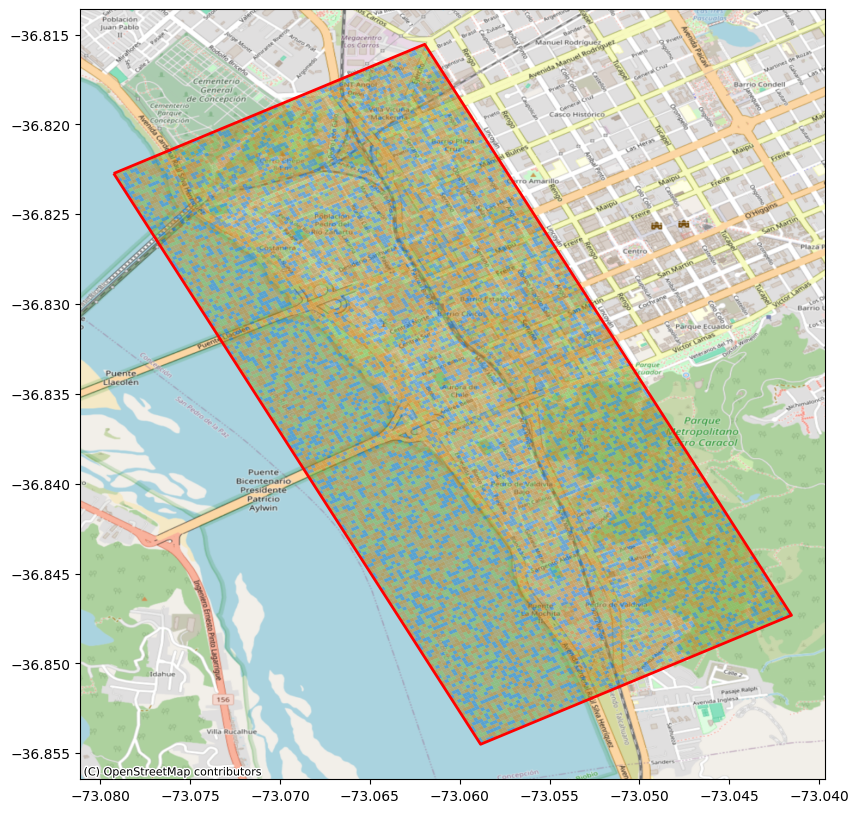

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

grid.plot(
    ax=ax,
    color=grid['color_hex'],
    alpha=0.6,
    markersize=100,
    )

bounding_gdf.boundary.plot(
    ax=ax,
    edgecolor='red',
    linewidth=2,
    )

ctx.add_basemap(
    ax,
    crs=grid.crs,
    source=ctx.providers.OpenStreetMap.Mapnik,
    )

plt.show()

## Tratamiento para las amenities

In [143]:
amenities = gpd.read_parquet('/app/assets/amenities/actual.parquet')
amenities.set_crs('EPSG:4326', inplace=True)
pass

In [144]:
amenities_filtered = gpd.overlay(amenities, bounding_gdf)
pass

In [145]:
amenities_filtered = gpd.sjoin(grid, amenities_filtered)

In [146]:
amenities_per_category_in_grid = pd.DataFrame(amenities_filtered.value_counts(subset=['category', 'id'])).reset_index()
amenities_per_category_in_grid.rename(columns={0: 'count'}, inplace=True)

In [147]:
amenities_total_in_grid = pd.DataFrame(amenities_filtered.value_counts(subset=['id'])).reset_index()
amenities_total_in_grid.rename(columns={0: 'count'}, inplace=True)

In [148]:
amenities_per_category_in_grid_with_total = pd.merge(amenities_per_category_in_grid, amenities_total_in_grid, on=['id'], suffixes=['_cat', '_total'])

In [149]:
amenities_per_category_in_grid_with_total['portion'] = amenities_per_category_in_grid_with_total['count_cat']/amenities_per_category_in_grid_with_total['count_total']

In [174]:
category_on_grid_with_total = amenities_per_category_in_grid_with_total.groupby('id').agg(
    n_cat=('category', 'nunique'),
    count_total=('count_total', 'first')  # Se asume que count_total es igual para cada id
).reset_index()

<Axes: xlabel='count_total', ylabel='n_cat'>

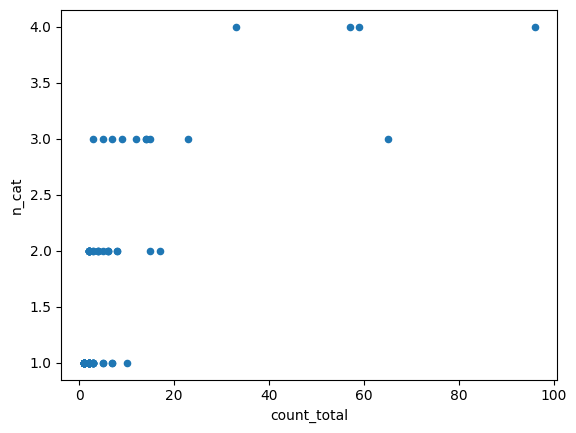

In [175]:
category_on_grid_with_total.plot(kind='scatter', x='count_total', y='n_cat')

## Tratamiento de las edificaciones

In [211]:
buildings = gpd.read_parquet('/app/assets/buildings/actual.parquet')
buildings.to_crs(4326, inplace=True)
pass

In [212]:
buildings_on_grid = gpd.overlay(grid, buildings)
buildings_on_grid = buildings_on_grid[['id', 'Pisos', 'Metros', 'geometry']]

In [213]:
max_values_by_grid = buildings_on_grid.groupby('id').agg({
    'Pisos': 'max',
    'Metros': 'max',
}).reset_index()

In [214]:
import numpy as np
buildings_on_grid['log(Metros)'] = np.log10(buildings_on_grid['Metros'])
buildings_on_grid['log_n(Metros)'] = buildings_on_grid['log(Metros)']/buildings_on_grid['log(Metros)'].max()

buildings_on_grid['Metros_n'] = buildings_on_grid['Metros']/buildings_on_grid['Metros'].max()

In [334]:
# Agrupar por 'id' y obtener el valor máximo de 'Pisos' y 'Metros'
buildings_on_grid_max = buildings_on_grid.groupby('id').agg({'Pisos': 'max', 'Metros': 'max'}).reset_index()

buildings_out = grid.merge(buildings_on_grid_max[['id', 'Pisos', 'Metros']], on='id', how='left')
buildings_out.fillna(0, inplace=True)

import math
# Actualizar la columna 'height' basándose en la columna 'Metros' y redondeando al entero superior
buildings_out['height'] = buildings_out['Metros'].apply(lambda x: [0, math.ceil(x), math.ceil(2 * x)])

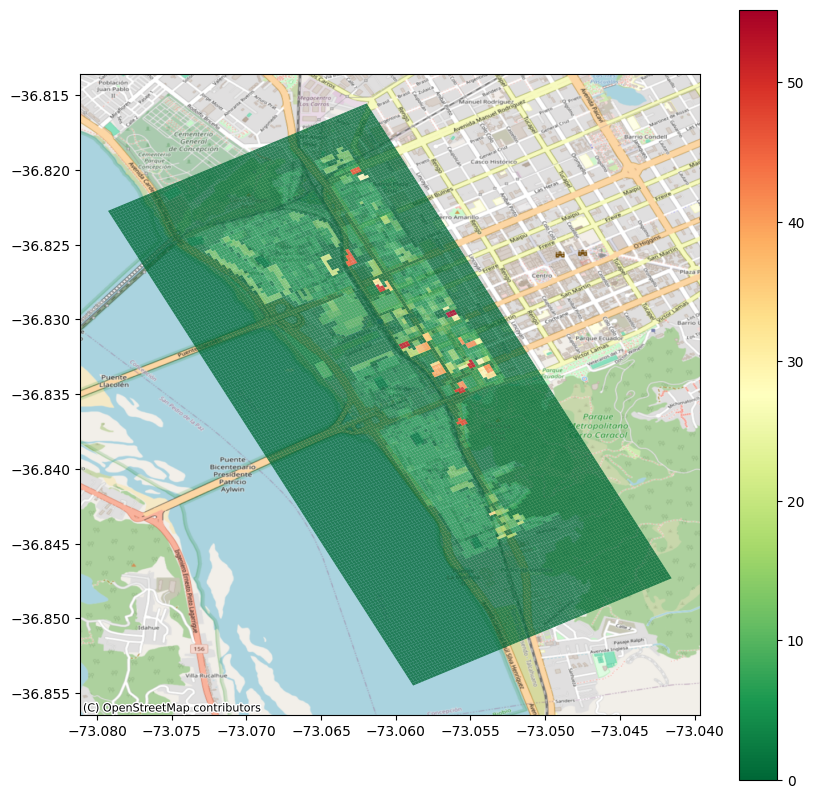

In [330]:
# Crear el plot
fig, ax = plt.subplots(figsize=(10, 10))

plot_col = 'Metros'

# Plotear el GeoDataFrame usando la columna 'value_column' para la escala de colores
buildings_out.plot(
    column=plot_col,
    cmap='RdYlGn_r',
    legend=True,
    ax=ax,
    alpha=0.8,
)

# Agregar un mapa de fondo si es necesario
ctx.add_basemap(
    ax,
    crs=buildings_out.crs.to_string(),
    source=ctx.providers.OpenStreetMap.Mapnik,
)

# Mostrar el plot
plt.show()

## Tratamiento usos de suelo

In [97]:
landuses = gpd.read_parquet('/app/data/land_uses_clean.parquet')

In [98]:
delete_categories = [
    'MULTI ROL',
    'PRE ROL',
]

landuses = landuses[~landuses['Uso'].isin(delete_categories)]

In [206]:
landuses_on_grid = gpd.overlay(grid, landuses)
landuses_on_grid_cols = ['id', 'Uso', 'geometry']
landuses_on_grid = landuses_on_grid[landuses_on_grid_cols]

In [207]:
landuses_on_grid.to_crs(32718, inplace=True)
landuses_on_grid['area'] = landuses_on_grid.area

In [208]:
count_records_by_id = pd.DataFrame(landuses_on_grid.value_counts(subset=['id'])).reset_index()
count_records_by_id.rename(columns={0: 'count'}, inplace=True)

In [300]:
id_with_one_landuses = count_records_by_id[count_records_by_id['count']==1]['id']
landuses_out = [landuses_on_grid[landuses_on_grid['id'].isin(id_with_one_landuses)].to_crs(4326)]

landuses_on_grid_filtered = landuses_on_grid.loc[~landuses_on_grid['id'].isin(id_with_one_landuses), ['id', 'Uso', 'area']]

In [287]:
# pd.set_option('display.max_rows', 25)
df = landuses_on_grid_filtered[['id', 'Uso', 'area']].groupby(['id', 'Uso']).agg({'area': 'sum'}).reset_index()

In [288]:
# Obtener los índices de las filas con el área máxima para cada id
idx = df.groupby(['id'])['area'].idxmax()

# Seleccionar esas filas del DataFrame original
max_land_uses = df.loc[idx].reset_index(drop=True)

# Agrupar por 'id' y contar los tipos de 'Uso' distintos para cada 'id'
count_land_uses = df.groupby('id')['Uso'].nunique().reset_index()

# Renombrar la columna de conteo a 'count_land_uses'
count_land_uses = count_land_uses.rename(columns={'Uso': 'count_land_uses'})

In [301]:
landuses_out.append(landuses_on_grid[landuses_on_grid['id'].isin(max_land_uses['id'])].to_crs(4326))

In [303]:
landuses_out = pd.concat(landuses_out)
landuses_out = gpd.GeoDataFrame(data=landuses_out.drop(columns=['geometry']), geometry=landuses_out['geometry'])

In [305]:
import pandas as pd

# Crear el diccionario con los nombres y valores hexadecimales
color_dict = {
    'SITIO ERIAZO': '#E57373',
    'HABITACIONAL': '#81C784',
    'EDUCACION Y CULTURA': '#64B5F6',
    'BODEGA Y ALMACENAJE': '#F06292',
    'BIENES COMUNES': '#DCE775',
    'OTROSnew_grid': '#4DD0E1',
    'INDUSTRIA': '#BA68C8',
    'SALUD': '#FFB74D',
    'CULTO': '#9575CD',
    'OFICINA': '#AED581',
    'COMERCIO': '#F48FB1',
    'TRANSPORTE Y TELEC': '#B0BEC5',
    'AREAS VERDES': '#4CAF50',
    'DEPORTE Y RECREACION': '#7986CB',
    'HOTEL, MOTEL': '#F06292',
    'ESTACIONAMIENTO': '#00ACC1',
    'ADM PUBLICA Y DEFENSA': '#EF5350',
    'AGRICOLA': '#8BC34A'
}

# Convertir el diccionario en un DataFrame
df_color_config = pd.DataFrame(list(color_dict.items()), columns=['Uso', 'color_hex'])

# Función para convertir hexadecimal a [R, G, B]
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]

# Agregar la columna RGB al DataFrame
df_color_config['color'] = df_color_config['color_hex'].apply(hex_to_rgb)

In [306]:
landuses_on_grid_with_color = pd.merge(landuses_out, df_color_config, on=['Uso'])

In [394]:
landuses_on_grid_with_color

,id,Uso,area,geometry,color_hex,color
0,1687,SITIO ERIAZO,0.410631,"POLYGON ((-73.07417 -36.82462, -73.07415 -36.8...",#E57373,"[229, 115, 115]"
1,1692,SITIO ERIAZO,0.230096,"POLYGON ((-73.07326 -36.82425, -73.07325 -36.8...",#E57373,"[229, 115, 115]"
2,1698,SITIO ERIAZO,0.201706,"POLYGON ((-73.07195 -36.82370, -73.07194 -36.8...",#E57373,"[229, 115, 115]"
3,1774,SITIO ERIAZO,233.088368,"POLYGON ((-73.07418 -36.82483, -73.07428 -36.8...",#E57373,"[229, 115, 115]"
4,1775,SITIO ERIAZO,372.234619,"POLYGON ((-73.07398 -36.82474, -73.07418 -36.8...",#E57373,"[229, 115, 115]"
...,...,...,...,...,...,...
13918,7816,DEPORTE Y RECREACION,18.397241,"POLYGON ((-73.05615 -36.83077, -73.05612 -36.8...",#7986CB,"[121, 134, 203]"
13919,10693,DEPORTE Y RECREACION,36.853826,"POLYGON ((-73.05782 -36.83826, -73.05794 -36.8...",#7986CB,"[121, 134, 203]"
13920,10694,DEPORTE Y RECREACION,3.896458,"POLYGON ((-73.05782 -36.83826, -73.05783 -36.8...",#7986CB,"[121, 134, 203]"
13921,10781,DEPORTE Y RECREACION,106.107415,"POLYGON ((-73.05782 -36.83826, -73.05777 -36.8...",#7986CB,"[121, 134, 203]"


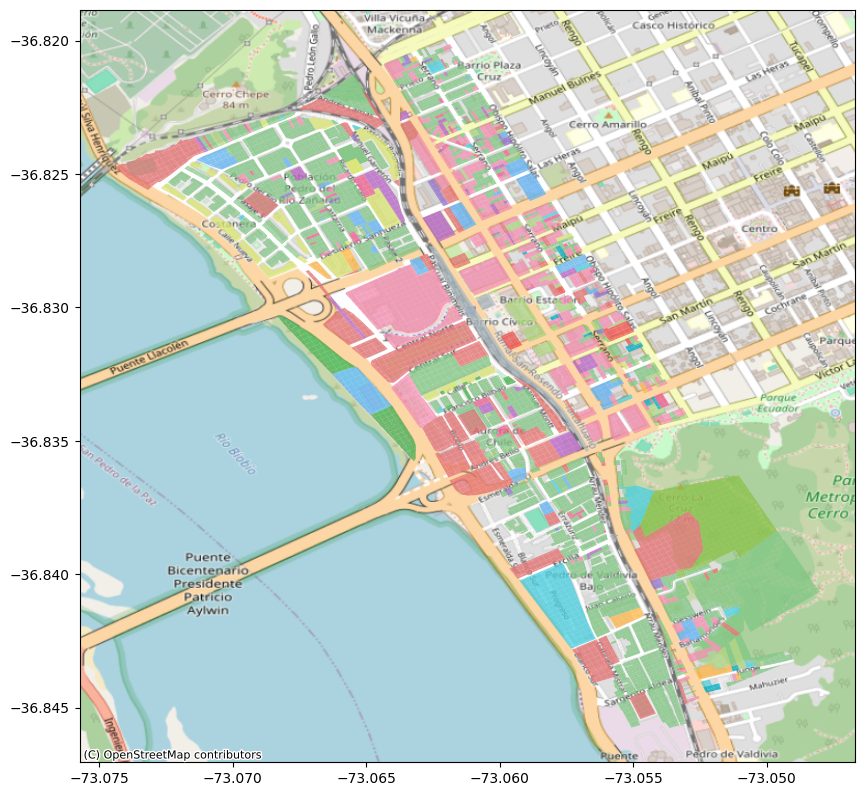

In [395]:
# Crear el plot
fig, ax = plt.subplots(figsize=(10, 10))

plot_col = 'Metros'

# Plotear el GeoDataFrame usando la columna 'value_column' para la escala de colores
landuses_on_grid_with_color.plot(
    color=landuses_on_grid_with_color['color_hex'],
    legend=True,
    ax=ax,
    alpha=0.8,
)

# Agregar un mapa de fondo si es necesario
ctx.add_basemap(
    ax,
    crs=buildings_out.crs.to_string(),
    source=ctx.providers.OpenStreetMap.Mapnik,
)

# Mostrar el plot
plt.show()

## Merging algunos cambios

In [398]:
new_grid = grid[['id', 'interactive']]

In [399]:
new_grid = pd.merge(new_grid, buildings_out[['id','height']], on=['id'])

In [400]:
new_grid = pd.merge(new_grid, landuses_on_grid_with_color[['id', 'Uso', 'color', 'color_hex']], on=['id'])
new_grid['name'] = new_grid['Uso']
del new_grid['Uso']

In [401]:
new_grid = pd.merge(new_grid, grid[['id', 'geometry']], on='id')

In [402]:
new_grid = gpd.GeoDataFrame(data=new_grid.drop(columns=['geometry']), geometry=new_grid['geometry'])

In [403]:
new_grid.to_parquet('/app/data/new_grid_cityscope.parquet')

In [405]:
# Crear el plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plotear el GeoDataFrame usando la columna 'value_column' para la escala de colores
new_grid.plot(
    color=new_grid['color_hex'],
    legend=True,
    ax=ax,
    alpha=0.8,
)

# Agregar un mapa de fondo si es necesario
ctx.add_basemap(
    ax,
    crs=buildings_out.crs.to_string(),
    source=ctx.providers.OpenStreetMap.Mapnik,
)

# Mostrar el plot
plt.show()